In [1]:
from Kaif.Algorithms.sota import FairBatch, FairFeatureDistillation, FairnessVAE, KernelDensityEstimator, LearningFromFairness
from Kaif.Metric import ClassificationMetric
from Kaif.DataSet import RawDataSet

from sample import AdultDataset, GermanDataset, PubFigDataset

2022-12-01 11:28:58.771320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/e/MAF_API/lib/python3.8/site-packages/cv2/../../lib64:
2022-12-01 11:28:58.771354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Trained on [[[  cpu  ]]] device.
Trained on [[[  cpu  ]]] device.
Train on [[[  cpu  ]]] device.
Train on [[[  cpu  ]]] device.
Train on [[[  cpu  ]]] device.


In [2]:
pubfig = PubFigDataset()

In [3]:
dataset = pubfig.to_dataset()

In [76]:
# Make privileged group and unprivileged group
privilege = [{key: value[0]} for key, value in zip(dataset['aif_dataset'].protected_attribute_names, dataset['aif_dataset'].privileged_protected_attributes)]
unprivilege = [{key: value[0]} for key, value in zip(dataset['aif_dataset'].protected_attribute_names, dataset['aif_dataset'].unprivileged_protected_attributes)]

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Flatten the images and convert numpy
fltn_img = np.array([img.ravel() for img in dataset['image_list']], dtype='int')

# Split the dataset
train_img, test_img, train_target, test_target, train_bias, test_bias = train_test_split(fltn_img, dataset['target'], dataset['bias'], train_size=0.7, shuffle=True)

In [77]:
# Fair feature distillation (Image only)
#protected_label = dataset_train.protected_attribute_names[0]
#protected_idx = dataset_train.feature_names.index(protected_label)
#biased = dataset_train.features[:, protected_idx]

# RawDataSet
train_data = RawDataSet(x=train_img, y=train_target, z=train_bias)
test_data = RawDataSet(x=test_img, y=test_target, z=test_bias)

# Train
n_epoch = 20
batch_size = 64
learning_rate = 0.01
image_shape = (3, 64, 64)
ffd = FairFeatureDistillation.FFD(train_data, n_epoch, batch_size, learning_rate, image_shape)
ffd.train_teacher()
ffd.train_student()

Train teacher start
Epoch [1/20], Batch [0/35], Loss 0.7240089774131775
Epoch [1/20], Batch [10/35], Loss 0.8165768384933472
Epoch [1/20], Batch [20/35], Loss 0.7046980261802673
Epoch [1/20], Batch [30/35], Loss 0.6610365509986877
Epoch [2/20], Batch [0/35], Loss 0.649886965751648
Epoch [2/20], Batch [10/35], Loss 0.7583650350570679
Epoch [2/20], Batch [20/35], Loss 0.6473614573478699
Epoch [2/20], Batch [30/35], Loss 0.6765059232711792
Epoch [3/20], Batch [0/35], Loss 0.8173194527626038
Epoch [3/20], Batch [10/35], Loss 0.5341435670852661
Epoch [3/20], Batch [20/35], Loss 0.5895872712135315
Epoch [3/20], Batch [30/35], Loss 0.6106736660003662
Epoch [4/20], Batch [0/35], Loss 0.4995141923427582
Epoch [4/20], Batch [10/35], Loss 0.6285754442214966
Epoch [4/20], Batch [20/35], Loss 0.5878218412399292
Epoch [4/20], Batch [30/35], Loss 0.5327085256576538
Epoch [5/20], Batch [0/35], Loss 0.5292989015579224
Epoch [5/20], Batch [10/35], Loss 0.674863338470459
Epoch [5/20], Batch [20/35], Loss

Epoch [19/20], Batch [20/35], Loss 2.024418354034424
Epoch [19/20], Batch [30/35], Loss 2.1895289421081543
Epoch [20/20], Batch [0/35], Loss 1.4865399599075317
Epoch [20/20], Batch [10/35], Loss 2.039121150970459
Epoch [20/20], Batch [20/35], Loss 2.4059457778930664
Epoch [20/20], Batch [30/35], Loss 2.1663427352905273
Train student end.


TypeError: evaluation() takes 1 positional argument but 3 were given

In [78]:
# Prediction
pred = ffd.evaluation()

Evaluation finished.


In [1]:
import pandas as pd
import os
from MAF.DataSet import aifData
from MAF.Metric import DataMetric, ClassificationMetric

from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('./MAF/CelebA_samples.csv')
dataset = aifData(df=df, label_name='Male', favorable_classes=[1], protected_attribute_names=['Heavy_Makeup'], privileged_classes=[[1]])

In [38]:
priv_val = dataset.privileged_protected_attributes[0][0]
unpriv_val = dataset.unprivileged_protected_attributes[0][0]

df = dataset.convert_to_dataframe()[0]
df_priv = df.loc[ df[dataset.protected_attribute_names[0]] == priv_val ]
df_unpriv = df.loc[ df[dataset.protected_attribute_names[0]] == unpriv_val ]
data_priv = aifData(df=df_priv, label_name=dataset.label_names[0],
                   favorable_classes=[dataset.favorable_label],
                   protected_attribute_names=dataset.protected_attribute_names,
                   privileged_classes=dataset.privileged_protected_attributes)
data_unpriv = aifData(df=df_unpriv, label_name=dataset.label_names[0],
                   favorable_classes=[dataset.favorable_label],
                   protected_attribute_names=dataset.protected_attribute_names,
                   privileged_classes=dataset.privileged_protected_attributes)

In [39]:
tsne_priv = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(data_priv.features)
tsne_unpriv = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(data_unpriv.features)

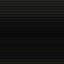

In [12]:
# Image
from PIL import Image
import numpy as np

Image.fromarray(dataset.features[0], mode='RGB').resize((64, 64))

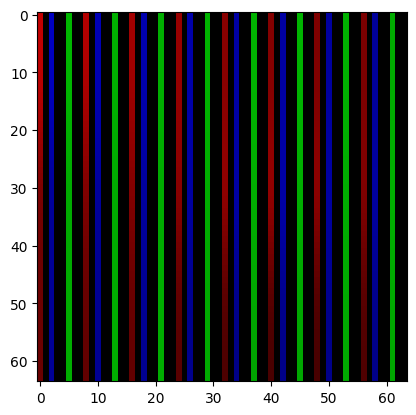

In [40]:
im0 = df.iloc[54, 2:].values.reshape((3, 64, 64))
im = Image.fromarray(im0, mode='RGB').resize((64, 64))

from matplotlib.pyplot import imshow

imshow(im)

In [41]:
im.size

(64, 64)